In [1]:
import numpy as np
import pandas as pd
import GPy
import time
import sys
import os
import pdb
import matplotlib.pyplot as plt

from context import aep
from context import load_data
from context import delete_blocks
from context import start_df
from context import save_df
from context import metrics
from thesis_work.plots import GP_figures
from thesis_work.plots import SGP_figures
from thesis_work.plots import DGP_figures

from baseline_models import full_GP_reg
from baseline_models import sparse_GP_reg
from aep_config import cont_optimization
from aep_config import aep_DGP_reg

default_dict = {'M': 50, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':100,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': []}
os.getcwd()
%matplotlib notebook

# Load data: normalise, delete blocks

Dataset size:  2500  Test size:  1000.0
Training:  1250


<IPython.core.display.Javascript object>


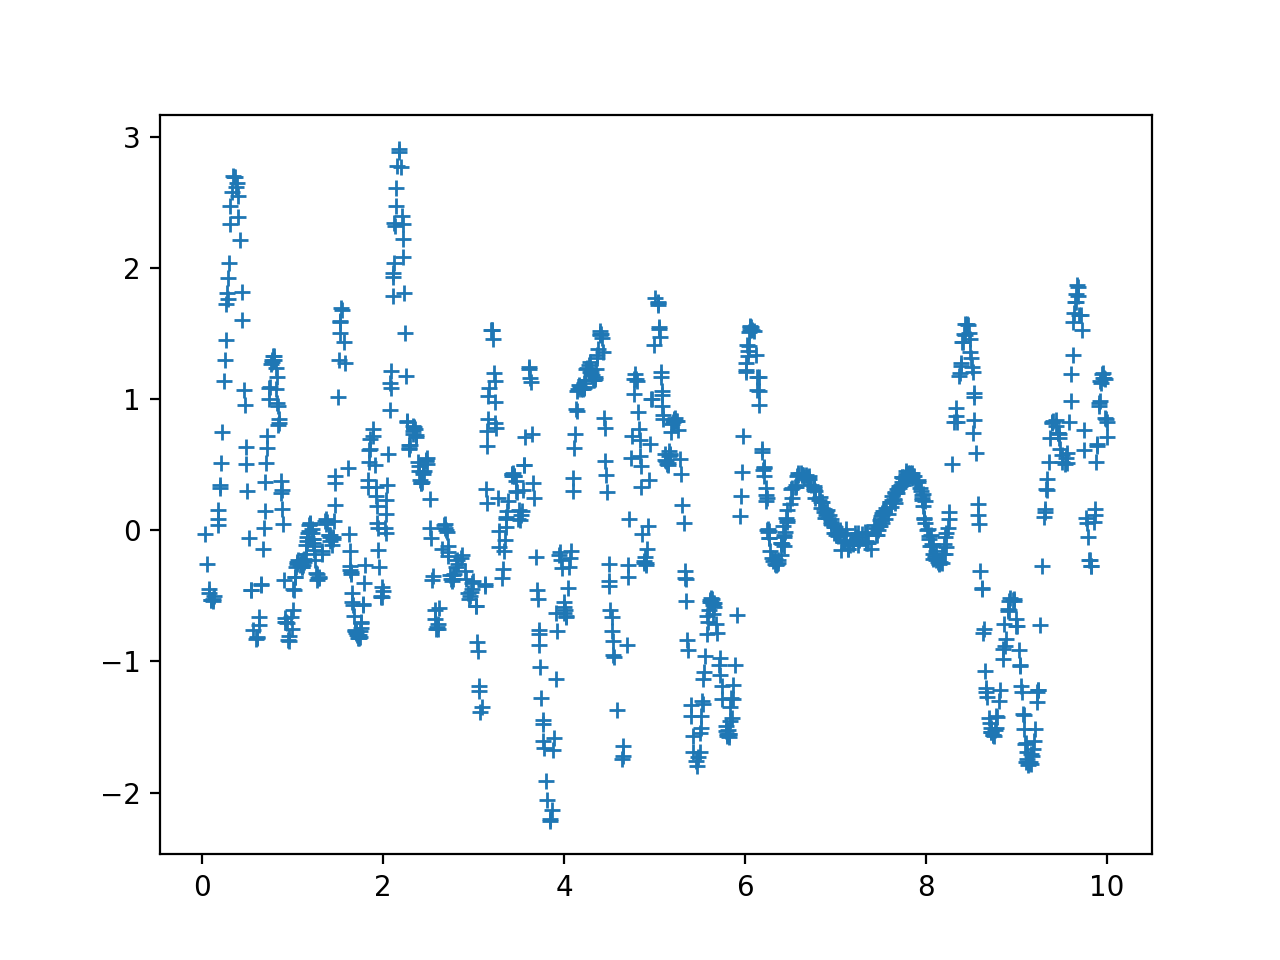

In [2]:
path = 'data/sample_5.txt'
X_train, y_train, X_test, y_test = load_data(path, N_train=1250, test=0.4, norm_out=False)
# X_test, y_test = delete_blocks(X_test, y_test,
#                                intervals=[2,4,8,9])
plt.figure()
plt.plot(X_test, y_test, '+')
plt.show()

## Sparse GP

In [3]:
model_sgp, df = sparse_GP_reg(X_train, y_train, X_test, y_test, M=75)
fig = SGP_figures(model_sgp).plot()

create SGP model and optimize ...
Test MSE =0.018, NLL =-0.424


<IPython.core.display.Javascript object>

# AEP Deep GPs

In [5]:
N_train = X_train.shape[0]
# ['zu_0', 'sf_0', 'ls_0', 'eta2_0', 'eta1_R_0']
config_dict = {'M': 75, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':10,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': ['zu_0'],
            'init_type':'greedy'}

model, df, costs = aep_DGP_reg(X_train, y_train, X_test, y_test, 
				conf_dict= config_dict,
				return_cost=True)
fig0 = DGP_figures(model,conf_dict=config_dict).plot_cost(costs)

Create DGP model and optimize ...
Optimise with fixed:  ['zu_0']
SGP greedy initialisation
Perform sparse GP regression


LinAlgError: Matrix is not positive definite

In [6]:
config_dict2 = {'M': 75, 'hidden_size': [2], 
			'optimizer':'adam', 'max_it':1000,
            'MB': 250, 'lr': 0.01, 'fixed_hyp': [],
            'init_type':'greedy'}
model, df = cont_optimization(model, X_test, y_test, conf_dict=config_dict2,
                              new_max_it=1000, return_cost=False)

iter 0 	 obj 0.066
iter 50 	 obj 0.165
iter 100 	 obj 0.042
iter 150 	 obj 0.093
iter 200 	 obj -0.005
iter 250 	 obj -0.013
iter 300 	 obj -0.041
iter 350 	 obj -0.043
iter 400 	 obj -0.012
iter 450 	 obj -0.048
iter 500 	 obj -0.062
iter 550 	 obj -0.036
iter 600 	 obj -0.222
iter 650 	 obj -0.143
iter 700 	 obj -0.100
iter 750 	 obj -0.025
iter 800 	 obj -0.170
iter 850 	 obj -0.192
iter 900 	 obj -0.208
iter 950 	 obj -0.150
Test MSE= 0.019, NLL= -0.731, SN= 0.102


main_folder = 'scores/'
save_df(main_folder, df, name=config_dict['init_type']+'-5')

### Fitting plots

<IPython.core.display.Javascript object>


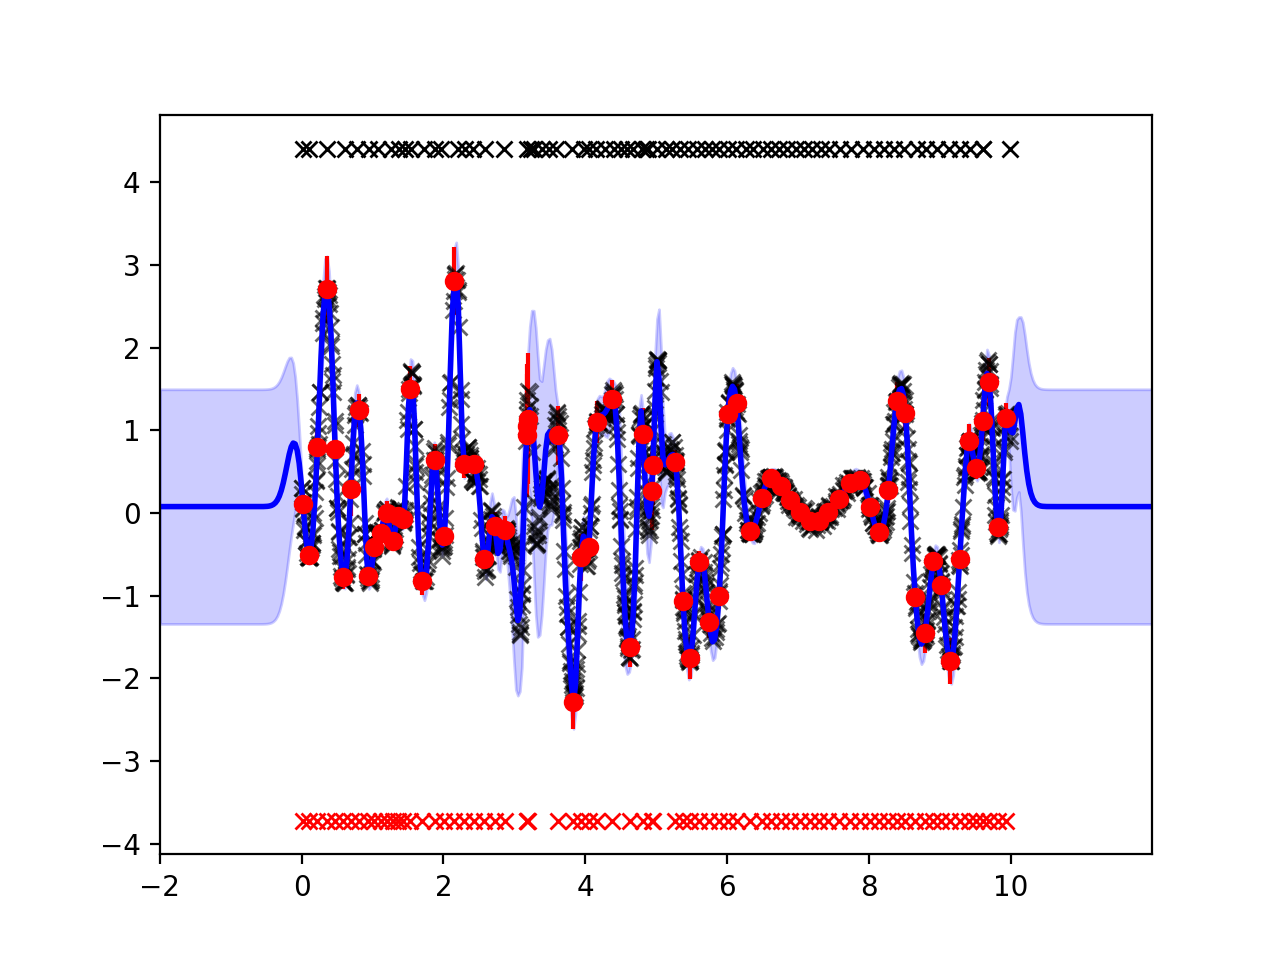

SGP greedy initialisation
Perform sparse GP regression
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0


<IPython.core.display.Javascript object>


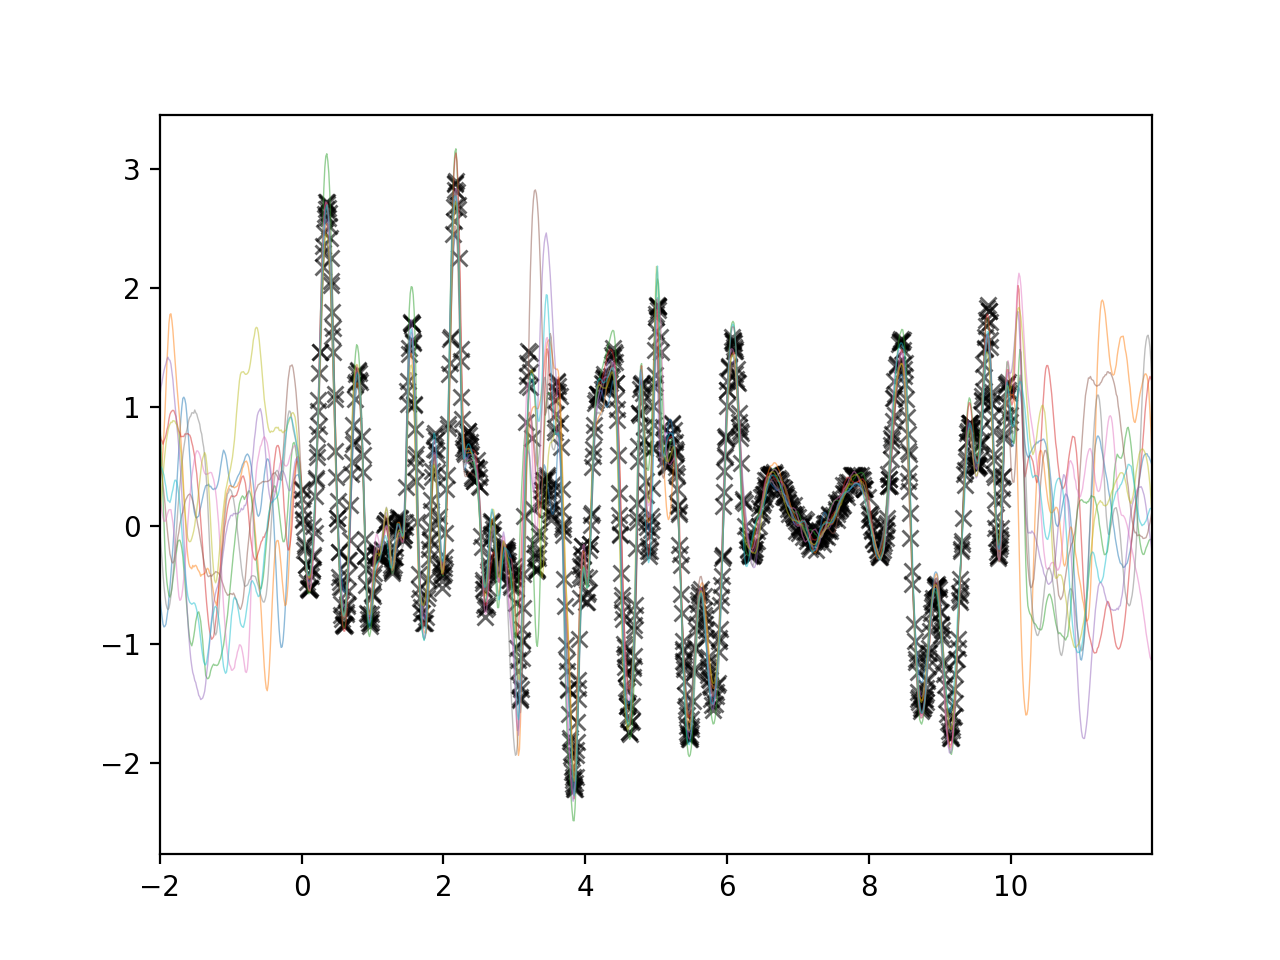

In [7]:
fig1 = DGP_figures(model, config_dict).plot()
fig2 = DGP_figures(model, config_dict).plot_sample()

### Hidden Layer

Default initialisation


<IPython.core.display.Javascript object>


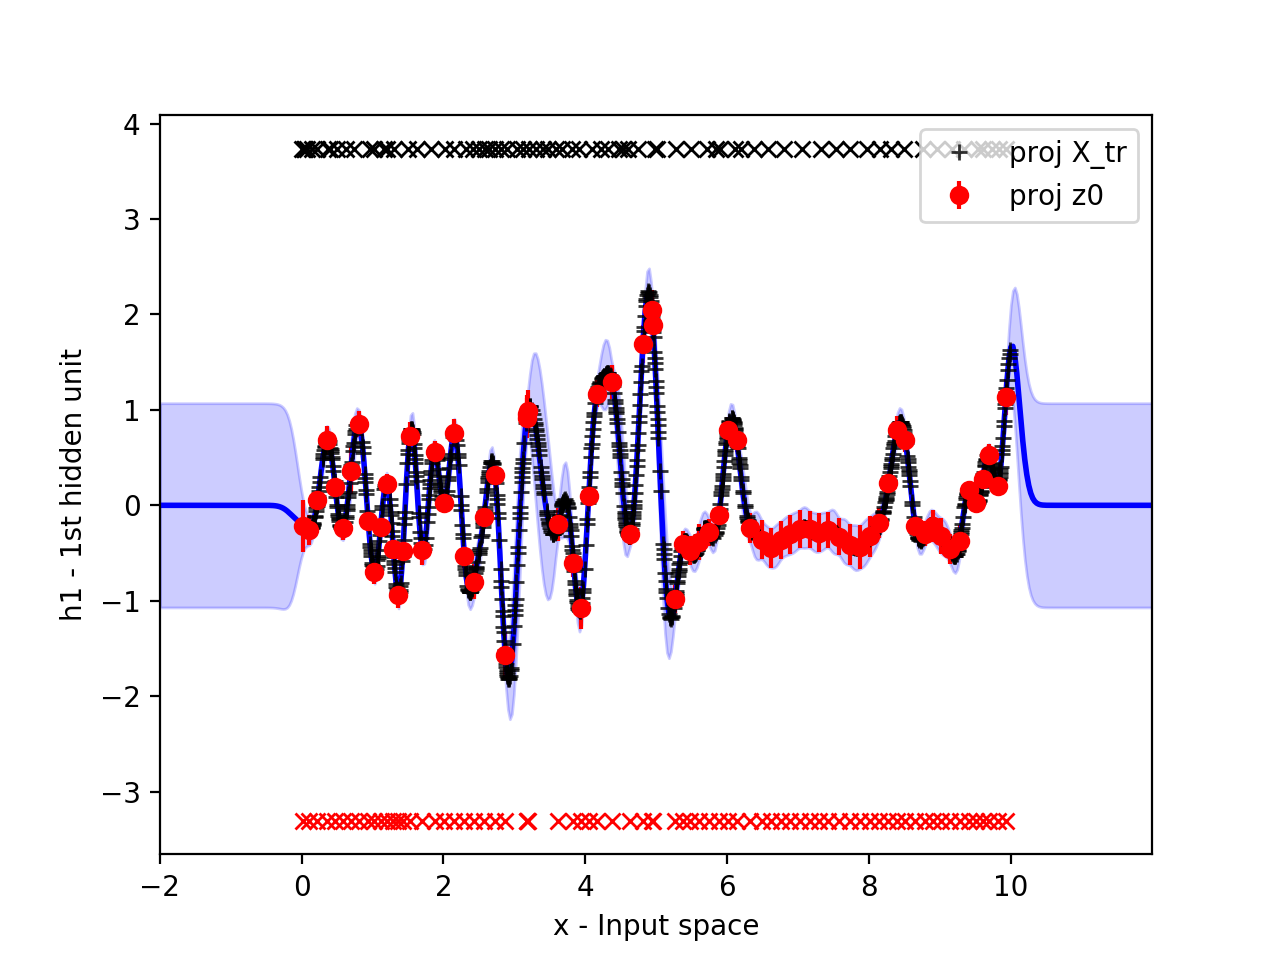

<IPython.core.display.Javascript object>


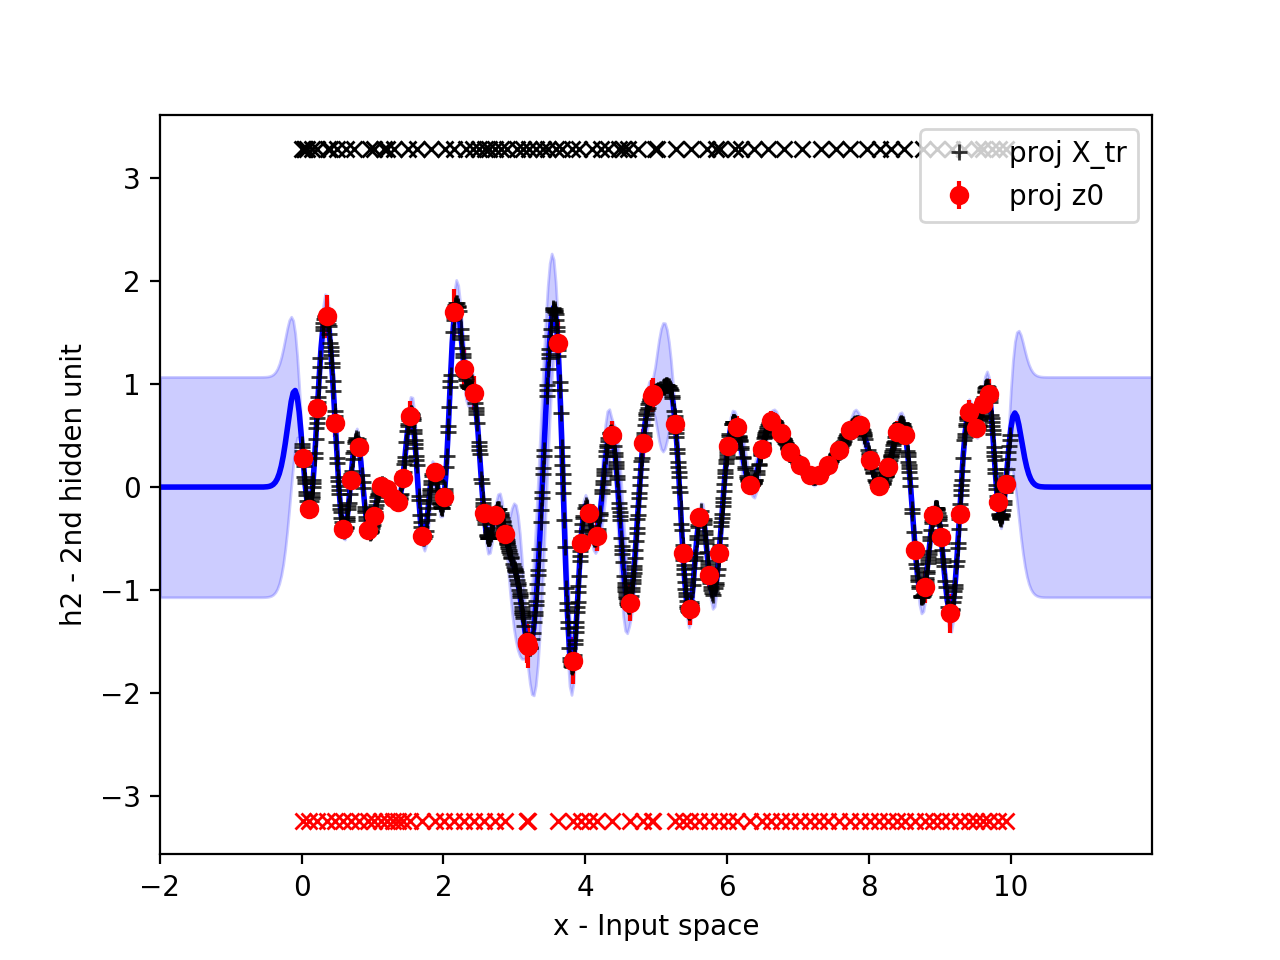

In [8]:
fig3 = DGP_figures(model, conf_dict=config_dict).plot_in_h()

Default initialisation


<IPython.core.display.Javascript object>


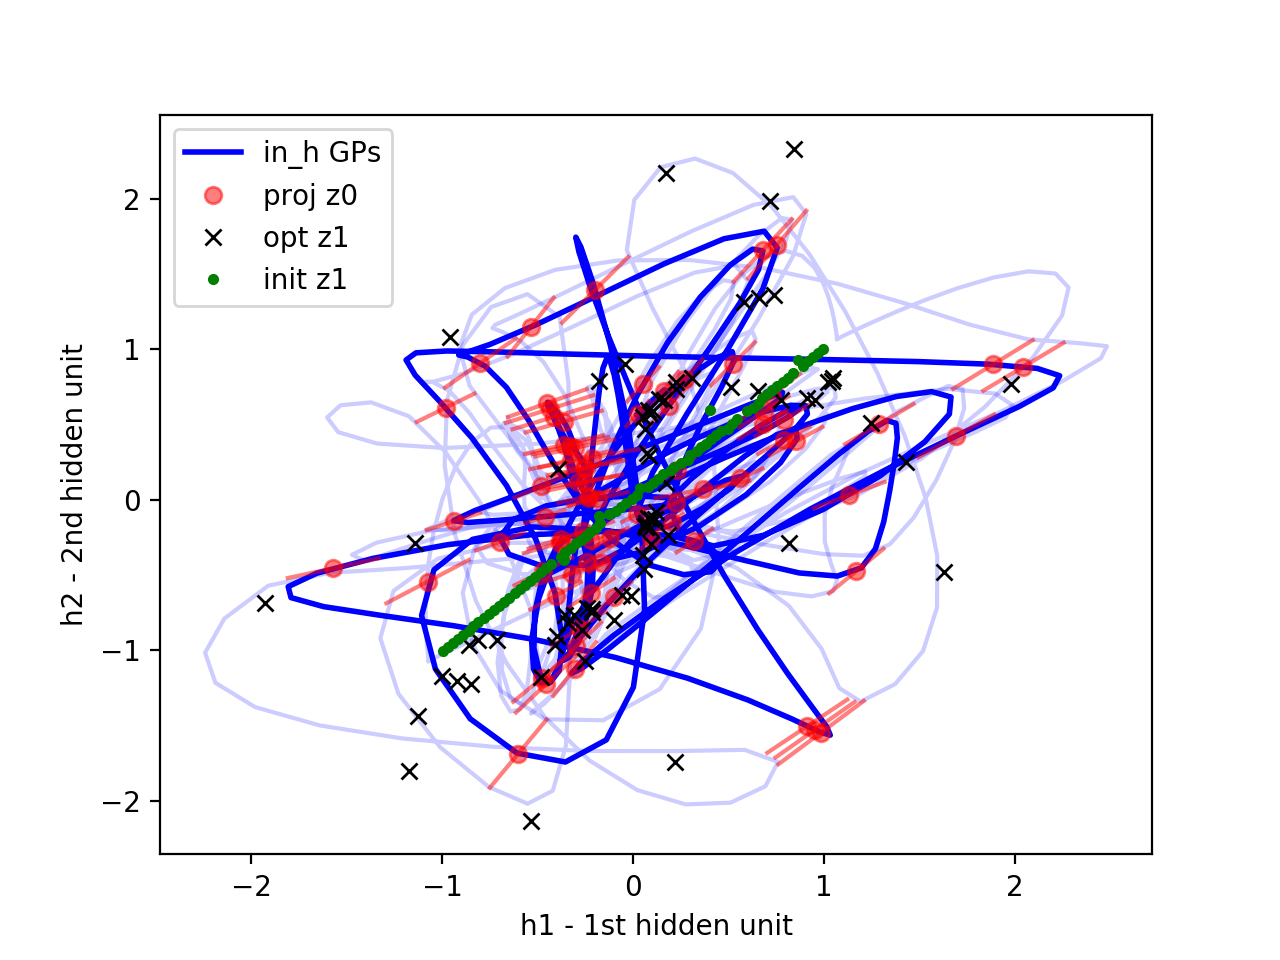

In [9]:
fig4 = DGP_figures(model, conf_dict=config_dict).plot_hidden()

Default initialisation


<IPython.core.display.Javascript object>


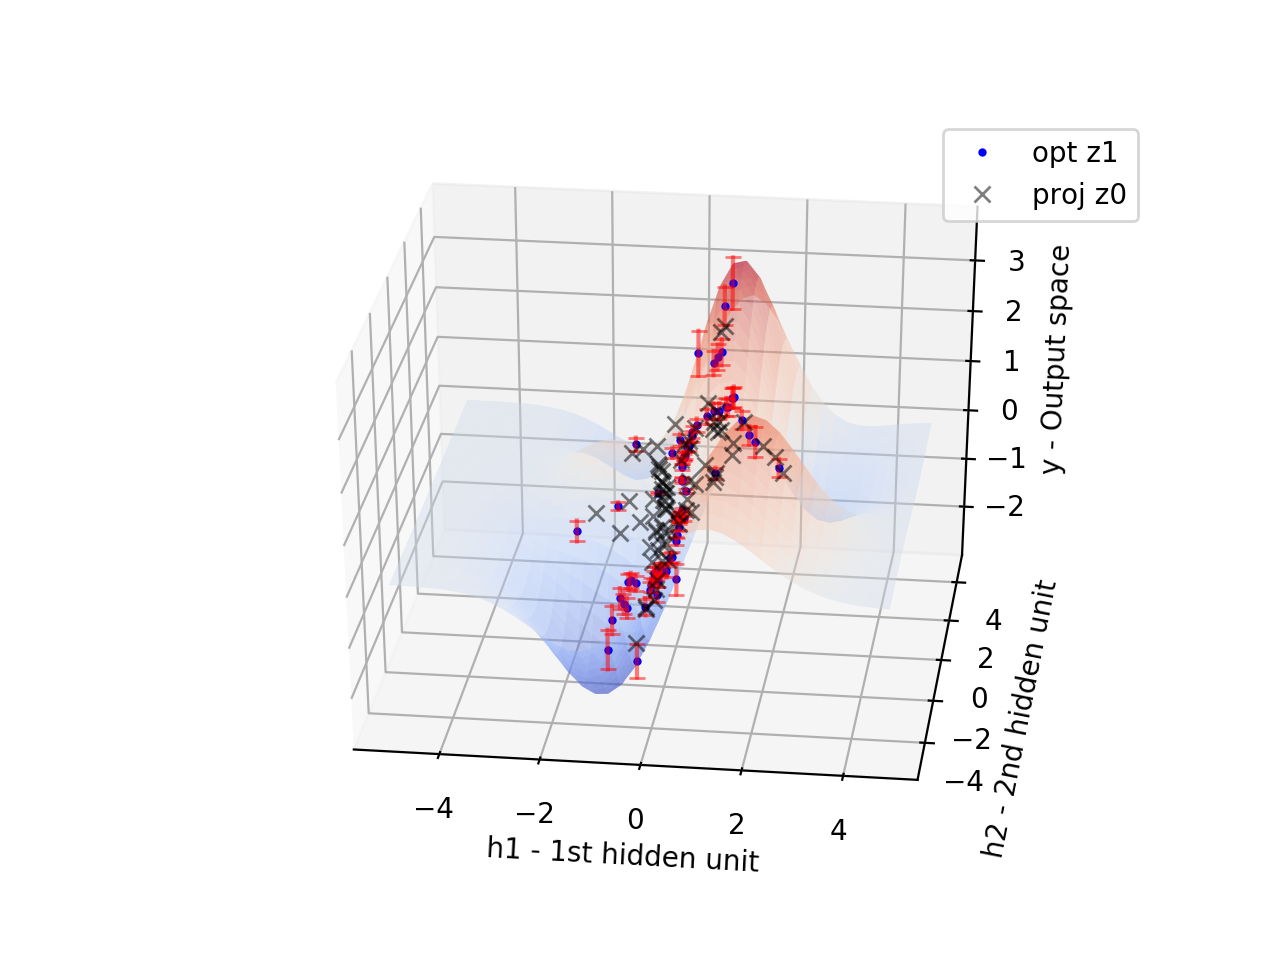

In [10]:
fig5 = DGP_figures(model, conf_dict=config_dict).plot_h_out()

### Initialisations

SGP greedy initialisation
Perform sparse GP regression
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0


<IPython.core.display.Javascript object>


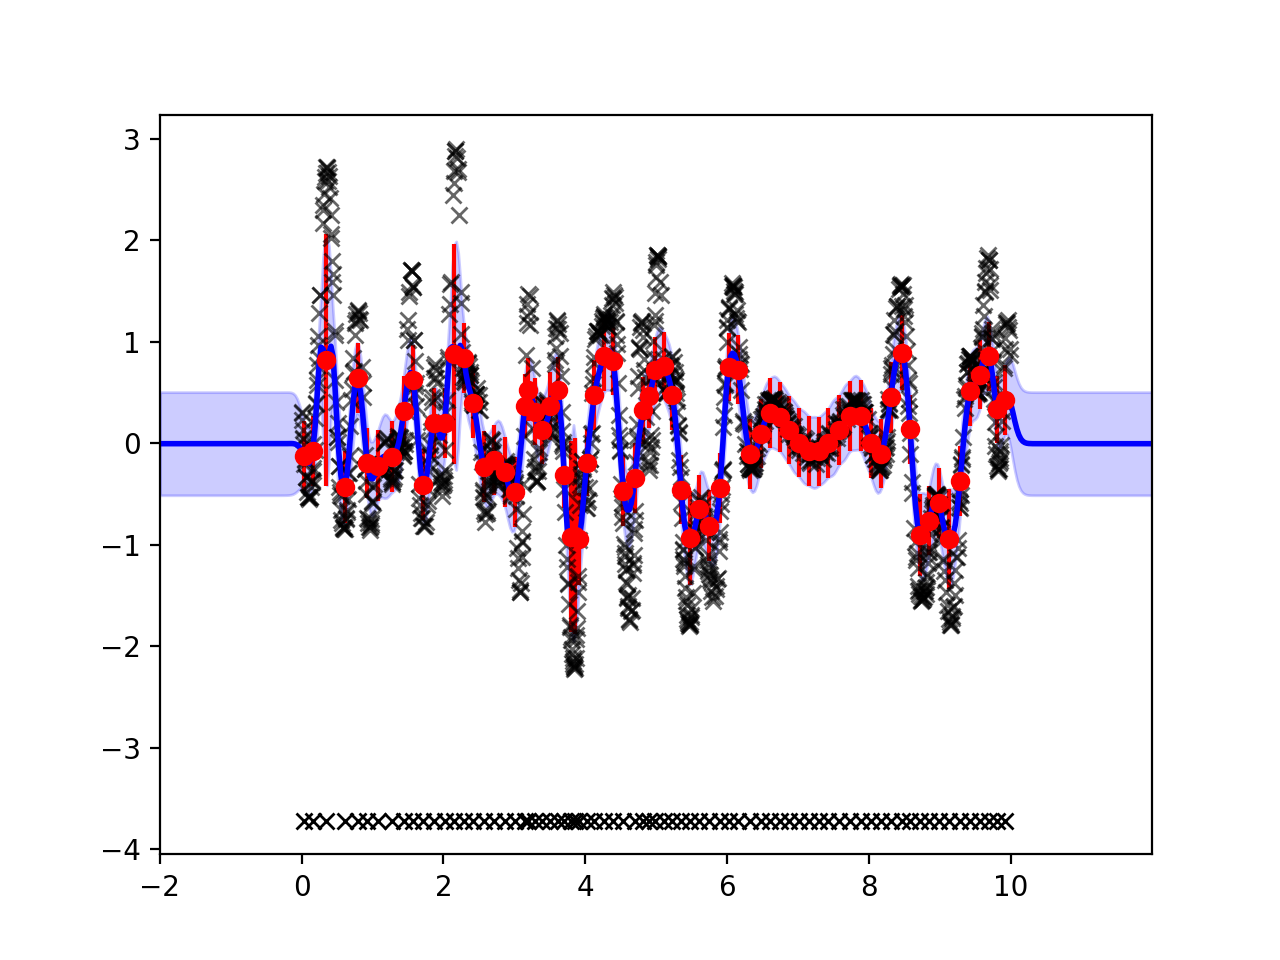

In [11]:
fig6 = DGP_figures(model, conf_dict=config_dict).plot_init()

SGP greedy initialisation
Perform sparse GP regression
sf_0
sn
ls_0
eta2_0
zu_0
eta1_R_0


<IPython.core.display.Javascript object>


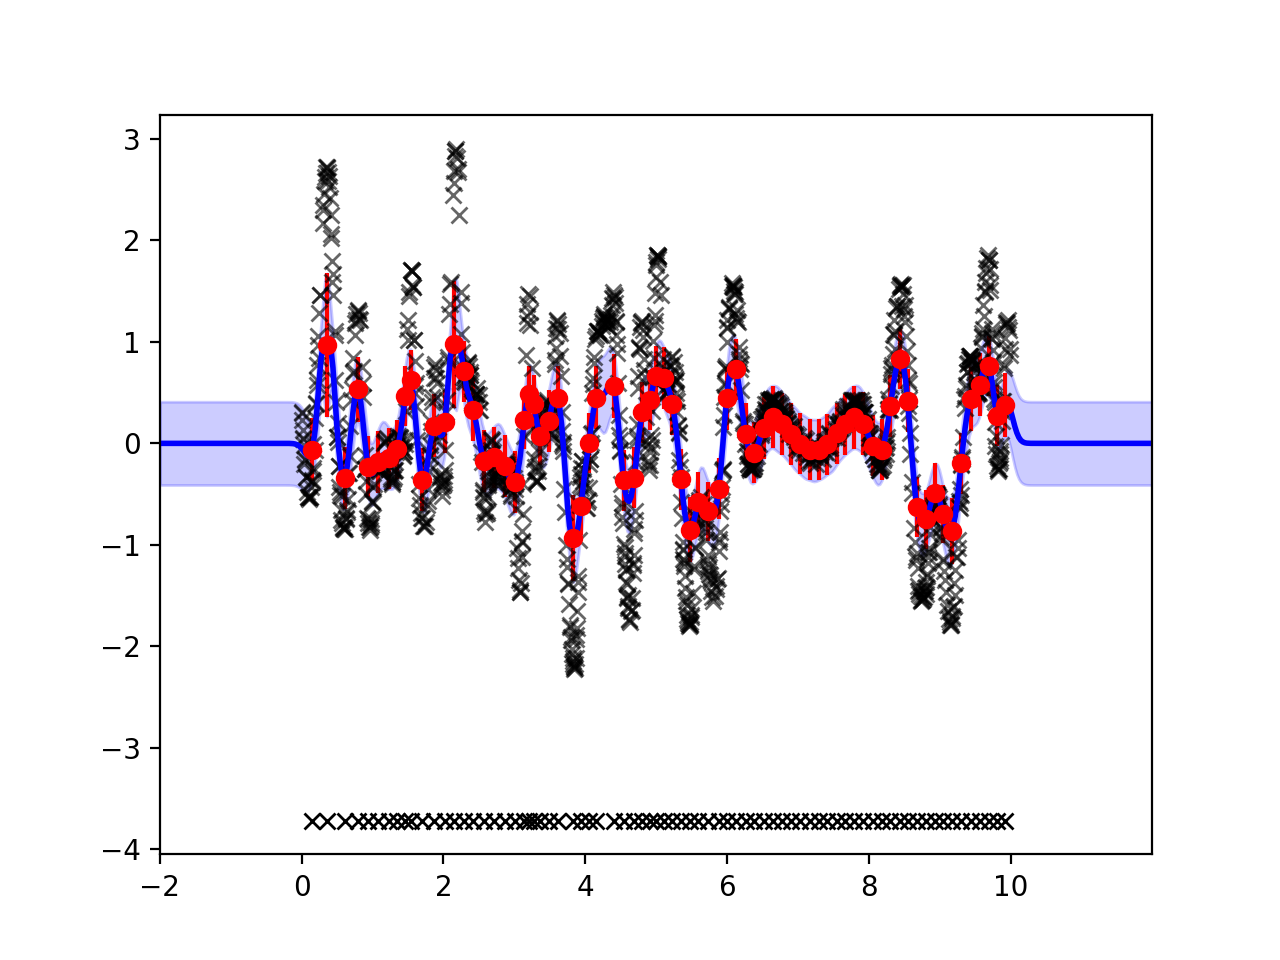

In [94]:
fig6 = DGP_figures(model, conf_dict=config_dict).plot_init()

# Baseline models

create full GP model and optimize ...
Test MSE =0.005, NLL =-1.267


<IPython.core.display.Javascript object>


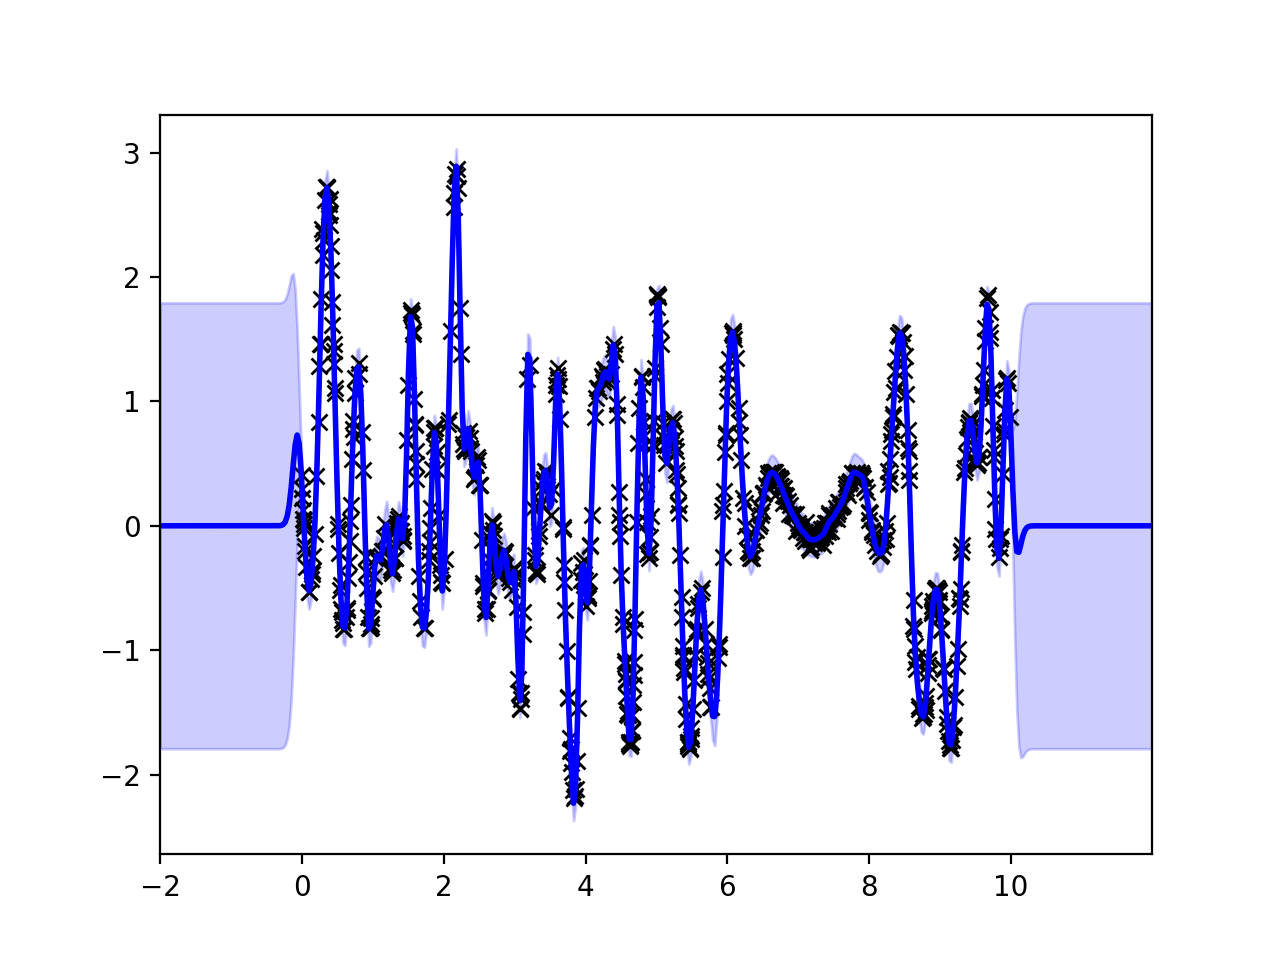

In [51]:
model_gp, df = full_GP_reg(X_train, y_train, X_test, y_test)
fig = GP_figures(model_gp).plot()

In [15]:
model_sgp = GPy.models.SparseGPRegression(X_train,y_train, kernel=GPy.kern.RBF(input_dim=1),num_inducing=50)
param = model_sgp.optimize('bfgs',messages=False)

In [16]:
zu = model_sgp.Z.values
sf = model_sgp.kern.variance.values
ls = model_sgp.kern.lengthscale.values
sn = model_sgp.likelihood.variance.values

In [17]:
def compute_kernel(lls, lsf, x, z):

    ls = np.exp(lls)
    sf = np.exp(lsf)

    if x.ndim == 1:
        x= x[ None, : ]

    if z.ndim == 1:
        z= z[ None, : ]

    r2 = cdist(x, z, 'seuclidean', V = ls)**2.0  
    k = sf * np.exp(-0.5*r2)
    return k
from scipy.spatial.distance import cdist
JITTER = 1e-5
M = 50
Dout = 1

Kuu = compute_kernel(2 * np.log(ls), 2 * np.log(sf), zu, zu)
# Kuu += np.diag(JITTER * np.ones((M, )))
Kuuinv = np.linalg.inv(Kuu)

In [18]:
print model_sgp.kern.K(zu)- Kuu

[[  1.00056757e-001   2.09137325e-251   2.58373358e-230 ...,
    3.25734980e-003   6.12440952e-055   2.22580786e-124]
 [  2.09137325e-251   1.00056757e-001   3.42721219e-002 ...,
    1.95506991e-291   4.35820532e-074   4.58659559e-024]
 [  2.58373358e-230   3.42721219e-002   1.00056757e-001 ...,
    1.11381667e-268   6.01399075e-063   4.40795604e-018]
 ..., 
 [  3.25734980e-003   1.95506991e-291   1.11381667e-268 ...,
    1.00056757e-001   3.21079592e-074   7.02528480e-153]
 [  6.12440952e-055   4.35820532e-074   6.01399075e-063 ...,
    3.21079592e-074   1.00056757e-001   5.13846560e-016]
 [  2.22580786e-124   4.58659559e-024   4.40795604e-018 ...,
    7.02528480e-153   5.13846560e-016   1.00056757e-001]]


In [19]:
Kuu = compute_kernel(2 * ls, 2 * sf, zu, zu)
Kuu += np.diag(JITTER * np.ones((M, )))
Kuuinv = np.linalg.inv(Kuu)

eta1_R = np.zeros((Dout, M * (M + 1) / 2))
eta2 = np.zeros((Dout, M))
for d in range(Dout):
    mu = np.linspace(-1, 1, M).reshape((M, 1))
    # mu += 0.01 * np.random.randn(M, 1)
    alpha = 0.5 * np.random.rand(M)
    # alpha = 0.1 * np.random.rand(M) # worse init obj = 44.2
    alpha = sn1 * np.random.rand(M)
    Su = np.diag(alpha)
    
    Suinv = np.diag(1 / alpha)
    theta2 = np.dot(Suinv, mu)
    # theta2 = np.dot(Suinv + Kuuinv, mu)
    theta1 = Suinv
    

    R = np.linalg.cholesky(theta1).T
    triu_ind = np.triu_indices(M)
    diag_ind = np.diag_indices(M)
    R[diag_ind] = np.log(R[diag_ind])
    eta1_d = R[triu_ind].reshape((M * (M + 1) / 2,))
    eta2_d = theta2.reshape((M,))
    eta1_R[d, :] = eta1_d
    eta2[d, :] = eta2_d

NameError: name 'sn1' is not defined

In [93]:
mu, Su = model_sgp.predict(zu, full_cov=True)
xx = np.linspace(0,10, 500).reshape(-1,1)
m, S = model_sgp.predict(xx)
Kuu = model_sgp.kern.K(zu)
Kuu += np.diag(1e-2* np.ones((M, )))
Kuuinv = np.linalg.inv(Kuu)
Suinv = np.linalg.inv(Su - np.diag(1e-1* np.ones((M, )))) 
theta1 = Suinv - Kuuinv + np.diag(1e-3* np.ones((M, )))
print np.min(np.linalg.eigvals(theta1))
np.linalg.cholesky(theta1).T

2.53898512968


array([[  7.44404435e+00,  -5.10264431e-13,  -4.33130118e-09, ...,
          3.74356367e-02,   1.17746155e-08,  -6.63065221e-12],
       [  0.00000000e+00,   7.00698153e+00,   4.72401406e-01, ...,
         -4.21039471e-10,  -7.27691052e-05,  -9.40852192e-03],
       [  0.00000000e+00,   0.00000000e+00,   7.11402422e+00, ...,
          5.25042220e-11,   4.90605441e-06,   1.04484510e-03],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          7.35007026e+00,  -2.39515823e-05,  -2.18202746e-07],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   7.46165582e+00,  -1.76264906e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   7.14911639e+00]])

eta1_R

In [33]:
eta1_R.shape

(1, 1275)

In [34]:
model_dgp = aep.SDGPR(X_train, y_train, 50, hidden_sizes=[2], lik='Gaussian')
params0 = model_dgp.optimise(method='adam', maxiter=1)

Default initialisation
iter 0 	 obj 41.159


In [35]:
for i in params0.keys():
    print i, params0[i].shape, params0[i]

zu_1 (50, 2) [[-1.001      -0.999     ]
 [-0.96018367 -0.96018367]
 [-0.91736735 -0.91936735]
 [-0.87655102 -0.87855102]
 [-0.83573469 -0.83773469]
 [-0.79491837 -0.79691837]
 [-0.75410204 -0.75610204]
 [-0.71328571 -0.71528571]
 [-0.67246939 -0.67446939]
 [-0.63165306 -0.63365306]
 [-0.59083674 -0.59283673]
 [-0.55002041 -0.55002041]
 [-0.51120408 -0.50920408]
 [-0.47038776 -0.46838776]
 [-0.42957143 -0.42757143]
 [-0.3887551  -0.3867551 ]
 [-0.34793878 -0.34593878]
 [-0.30712245 -0.30512245]
 [-0.26430612 -0.26430612]
 [-0.2234898  -0.2234898 ]
 [-0.18267347 -0.18467347]
 [-0.14185714 -0.14385714]
 [-0.10104082 -0.10304082]
 [-0.06022449 -0.06222449]
 [-0.01940816 -0.02140816]
 [ 0.02140816  0.01940816]
 [ 0.06222449  0.06022449]
 [ 0.10304082  0.10104082]
 [ 0.14385714  0.14185714]
 [ 0.18467347  0.18267347]
 [ 0.2254898   0.2234898 ]
 [ 0.26630612  0.26430612]
 [ 0.30712245  0.30512245]
 [ 0.34793878  0.34593878]
 [ 0.3887551   0.3867551 ]
 [ 0.42957143  0.42757143]
 [ 0.47038776  

In [36]:
params1 = model_dgp.optimise(method='adam', maxiter=100, reinit_hypers=False)

iter 0 	 obj 39.928
iter 50 	 obj 7.400


In [37]:
for i in params1.keys():
    print i, params1[i].shape

zu_1 (50, 2)
zu_0 (50, 1)
sf_0 (1,)
sf_1 (1,)
sn ()
ls_0 (1,)
ls_1 (2,)
eta2_1 (1, 50)
eta2_0 (2, 50)
eta1_R_1 (1, 1275)
eta1_R_0 (2, 1275)


In [80]:
zu.shape

(50, 1)

In [86]:
sn.shape

(1,)